In [108]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
std=StandardScaler()
#pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [109]:
covid=pd.read_csv("C:/Users/Ay/Documents/Data Sources/covid_19_data_indonesia.csv")
covid.head()

,N,Date,Province,Country,Last Update,Confirmed,Deaths,Recovered
0,1,03/02/2020,nan,Indonesia,2020-03-02T18:03:04,2.000000,0.000000,0.000000
1,2,03/03/2020,nan,Indonesia,2020-03-02T18:03:04,2.000000,0.000000,0.000000
2,3,03/04/2020,nan,Indonesia,2020-03-02T18:03:04,2.000000,0.000000,0.000000
3,4,03/05/2020,nan,Indonesia,2020-03-02T18:03:04,2.000000,0.000000,0.000000
4,5,03/06/2020,nan,Indonesia,2020-03-06T12:33:03,4.000000,0.000000,0.000000


In [110]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:  (96, 8)
Checking for null values:
 N               0
Date            0
Province       96
Country         0
Last Update     0
Confirmed       0
Deaths          0
Recovered       0
dtype: int64
Checking Data-type of each column:
 N                int64
Date            object
Province       float64
Country         object
Last Update     object
Confirmed      float64
Deaths         float64
Recovered      float64
dtype: object


In [111]:
#Dropping column as SNo is of no use, and "Province/State" contains too many missing values
covid.drop(["N"],1,inplace=True)

In [112]:
#Converting "Observation Date" into Datetime format
covid["Date"]=pd.to_datetime(covid["Date"])

In [113]:
grouped_country=covid.groupby(["Country","Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [114]:
grouped_country["Active Cases"]=grouped_country["Confirmed"]-grouped_country["Recovered"]-grouped_country["Deaths"]
grouped_country["log_confirmed"]=np.log(grouped_country["Confirmed"])
grouped_country["log_active"]=np.log(grouped_country["Active Cases"])

In [115]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["Date"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()

In [116]:
print("Basic Information")
print("Total number of Confirmed Cases in Indonesia: ",datewise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases in Indonesia: ",datewise["Recovered"].iloc[-1])
print("Total number of Deaths Cases in Indonesia: ",datewise["Deaths"].iloc[-1])
print("Total number of Active Cases in Indonesia: ",(datewise["Confirmed"].iloc[-1]-datewise["Recovered"].iloc[-1]-datewise["Deaths"].iloc[-1]))
print("Total number of Closed Cases in Indonesia: ",datewise["Recovered"].iloc[-1]+datewise["Deaths"].iloc[-1])
print("Approximate number of Confirmed Cases per Day in Indonesia: ",np.round(datewise["Confirmed"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Recovered Cases per Day in Indonesia: ",np.round(datewise["Recovered"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Death Cases per Day in Indonesia: ",np.round(datewise["Deaths"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Confirmed Cases per hour in Indonesia: ",np.round(datewise["Confirmed"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Recovered Cases per hour in Indonesia: ",np.round(datewise["Recovered"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Death Cases per hour in Indonesia: ",np.round(datewise["Deaths"].iloc[-1]/((datewise.shape[0])*24)))
print("Number of Confirmed Cases in last 24 hours in Indonesia: ",datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2])
print("Number of Recovered Cases in last 24 hours in Indonesia: ",datewise["Recovered"].iloc[-1]-datewise["Recovered"].iloc[-2])
print("Number of Death Cases in last 24 hours in Indonesia: ",datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2])

Basic Information
Total number of Confirmed Cases in Indonesia:  29521.0
Total number of Recovered Cases in Indonesia:  9443.0
Total number of Deaths Cases in Indonesia:  1770.0
Total number of Active Cases in Indonesia:  18308.0
Total number of Closed Cases in Indonesia:  11213.0
Approximate number of Confirmed Cases per Day in Indonesia:  308.0
Approximate number of Recovered Cases per Day in Indonesia:  98.0
Approximate number of Death Cases per Day in Indonesia:  18.0
Approximate number of Confirmed Cases per hour in Indonesia:  13.0
Approximate number of Recovered Cases per hour in Indonesia:  4.0
Approximate number of Death Cases per hour in Indonesia:  1.0
Number of Confirmed Cases in last 24 hours in Indonesia:  703.0
Number of Recovered Cases in last 24 hours in Indonesia:  551.0
Number of Death Cases in last 24 hours in Indonesia:  49.0


In [117]:
fig=px.bar(x=datewise.index,y=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Active Cases in Indonesia (As of 5 June 2020)",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

In [118]:
fig=px.bar(x=datewise.index,y=datewise["Recovered"]+datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Closed Cases in Indonesia (As of 5 June 2020)",
                  xaxis_title="Date",yaxis_title="Number of Cases")
fig.show()

In [119]:
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
w=1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekOfYear"]==i]["Recovered"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num.append(w)
    w=w+1

fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in Indonesia (As of 5 June 2020)",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Text(0.5, 1.0, 'Weekly increase in Number of Death Cases')

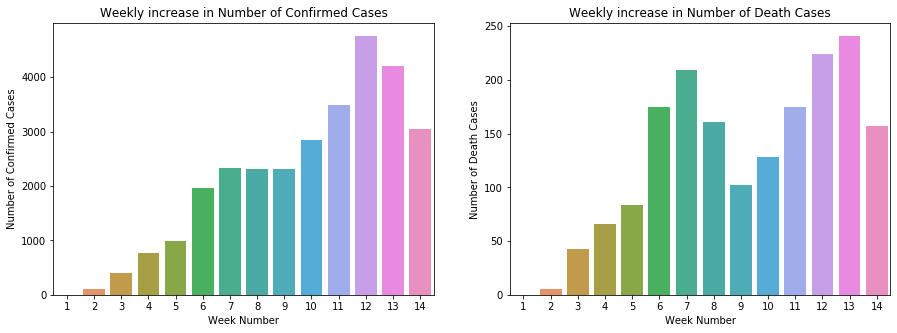

In [120]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.barplot(x=week_num,y=pd.Series(weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num,y=pd.Series(weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("Weekly increase in Number of Confirmed Cases")
ax2.set_title("Weekly increase in Number of Death Cases")

In [121]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases in Indonesia (As of 5 June 2020)",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [122]:
#Calculating the Mortality Rate and Recovery Rate
datewise["Mortality Rate"]=(datewise["Deaths"]/datewise["Confirmed"])*100
datewise["Recovery Rate"]=(datewise["Recovered"]/datewise["Confirmed"])*100
datewise["Active Cases"]=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"]
datewise["Closed Cases"]=datewise["Recovered"]+datewise["Deaths"]

print("Average Mortality Rate",datewise["Mortality Rate"].mean())
print("Median Mortality Rate",datewise["Mortality Rate"].median())
print("Average Recovery Rate",datewise["Recovery Rate"].mean())
print("Median Recovery Rate",datewise["Recovery Rate"].median())

#Plotting Mortality and Recovery Rate 
fig = make_subplots(rows=2, cols=1,
                   subplot_titles=("Recovery Rate", "Mortatlity Rate"))
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Recovered"]/datewise["Confirmed"])*100,name="Recovery Rate"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Deaths"]/datewise["Confirmed"])*100,name="Mortality Rate"),
    row=2, col=1
)
fig.update_layout(height=1000,legend=dict(x=-0.1,y=1.2,traceorder="normal"))
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Recovery Rate", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Mortality Rate", row=1, col=2)
fig.show()

Average Mortality Rate 6.699429965244313
Median Mortality Rate 7.310522894985059
Average Recovery Rate 12.877747200839556
Median Recovery Rate 10.3408225587049


In [123]:
print("Average increase in number of Confirmed Cases every day: ",np.round(datewise["Confirmed"].diff().fillna(0).mean()))
print("Average increase in number of Recovered Cases every day: ",np.round(datewise["Recovered"].diff().fillna(0).mean()))
print("Average increase in number of Deaths Cases every day: ",np.round(datewise["Deaths"].diff().fillna(0).mean()))

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().fillna(0),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"].diff().fillna(0),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().fillna(0),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of Cases in Indonesia (As of 5 June 2020)",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Average increase in number of Confirmed Cases every day:  307.0
Average increase in number of Recovered Cases every day:  98.0
Average increase in number of Deaths Cases every day:  18.0


In [124]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="7 Days Rolling Mean of Daily Increase of Confirmed, Recovered and Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [125]:
print("Average growth factor of number of Confirmed Cases: ",(datewise["Confirmed"]/datewise["Confirmed"].shift()).mean())
print("Median growth factor of number of Confirmed Cases: ",(datewise["Confirmed"]/datewise["Confirmed"].shift()).median())
print("Average growth factor of number of Recovered Cases: ",(datewise["Recovered"]/datewise["Recovered"].shift()).mean())
print("Median growth factor of number of Recovered Cases: ",(datewise["Recovered"]/datewise["Recovered"].shift()).median())
print("Average growth factor of number of Death Cases: ",(datewise["Deaths"]/datewise["Deaths"].shift()).mean())
print("Median growth factor of number of Death Cases: ",(datewise["Deaths"]/datewise["Deaths"].shift()).median())

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"]/datewise["Confirmed"].shift(),
                    mode='lines',
                    name='Growth Factor of Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"]/datewise["Recovered"].shift(),
                    mode='lines',
                    name='Growth Factor of Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"]/datewise["Deaths"].shift(),
                    mode='lines',
                    name='Growth Factor of Death Cases'))
fig.update_layout(title="Datewise Growth Factor of different types of cases in Indonesia (As of 5 June 2020)",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=-0.4,traceorder="normal"))
fig.show()

Average growth factor of number of Confirmed Cases:  1.1248845027482
Median growth factor of number of Confirmed Cases:  1.0481261795632246
Average growth factor of number of Recovered Cases:  inf
Median growth factor of number of Recovered Cases:  1.0581558337757153
Average growth factor of number of Death Cases:  inf
Median growth factor of number of Death Cases:  1.0319444444444446


In [126]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, 
                         y=(datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])/(datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"]).shift(),
                    mode='lines',
                    name='Growth Factor of Active Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=(datewise["Recovered"]+datewise["Deaths"])/(datewise["Recovered"]+datewise["Deaths"]).shift(),
                    mode='lines',
                    name='Growth Factor of Closed Cases'))
fig.update_layout(title="Datewise Growth Factor of Active and Closed Cases",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=-0.4,traceorder="normal"))
fig.show()

In [127]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [128]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [129]:
lin_reg=LinearRegression(normalize=True)

In [130]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [131]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [132]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  6462.4492691525165


In [133]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [134]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [135]:
poly = PolynomialFeatures(degree = 3) 

In [136]:
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Confirmed"]

In [137]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [138]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  141.21889006409666


In [139]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [140]:
new_prediction_poly=[]
for i in range(1,18):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [141]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [142]:
#Intializing SVR Model
svm=SVR(C=1,degree=5,kernel='poly',epsilon=0.01)

In [143]:
#Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

SVR(C=1, cache_size=200, coef0=0.0, degree=5, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [144]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [145]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  11328.322767197755


In [146]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [147]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [148]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction
0,2020-06-06,22633.279025,30437.192829,45671.341110
1,2020-06-07,22921.258640,31159.458079,47982.548494
2,2020-06-08,23209.238254,31890.989206,50391.054036
3,2020-06-09,23497.217869,32631.813738,52899.897979
4,2020-06-10,23785.197484,33381.959200,55512.183246
5,2020-06-11,24073.177098,34141.453117,58231.076085
6,2020-06-12,24361.156713,34910.323016,61059.806704
7,2020-06-13,24649.136327,35688.596421,64001.669910
8,2020-06-14,24937.115942,36476.300859,67060.025755
9,2020-06-15,25225.095557,37273.463856,70238.300166


In [149]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [150]:
holt=Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level=1.0, smoothing_slope=1.9,optimized=False)

In [151]:
y_pred["Holt"]=holt.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  3198.153484381553


In [152]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [153]:
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,18):
    holt_new_date.append(datewise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model Prediction"]=holt_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction
0,2020-06-06,22633.279025,30437.192829,45671.341110,35804.179909
1,2020-06-07,22921.258640,31159.458079,47982.548494,37359.376561
2,2020-06-08,23209.238254,31890.989206,50391.054036,38914.573212
3,2020-06-09,23497.217869,32631.813738,52899.897979,40469.769864
4,2020-06-10,23785.197484,33381.959200,55512.183246,42024.966515


In [154]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [155]:
es=ExponentialSmoothing(np.asarray(model_train['Confirmed']),seasonal_periods=7,trend='mul', seasonal='mul').fit()

In [156]:
y_pred["Holt's Winter Model"]=es.forecast(len(valid))

In [157]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  309.59810767196507


In [158]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt\'s Winter Model"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [159]:
holt_winter_new_prediction=[]
for i in range(1,18):
    holt_winter_new_prediction.append(es.forecast((len(valid)+i))[-1])
model_predictions["Holt's Winter Model Prediction"]=holt_winter_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction
0,2020-06-06,22633.279025,30437.192829,45671.341110,35804.179909,30885.619959
1,2020-06-07,22921.258640,31159.458079,47982.548494,37359.376561,31833.226391
2,2020-06-08,23209.238254,31890.989206,50391.054036,38914.573212,32292.869646
3,2020-06-09,23497.217869,32631.813738,52899.897979,40469.769864,32836.669257
4,2020-06-10,23785.197484,33381.959200,55512.183246,42024.966515,33805.186914


In [160]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [161]:
model_ar= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=5,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["Confirmed"])

Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1100.298, BIC=1105.275, Time=0.031 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1087.095, BIC=1094.561, Time=0.069 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=1085.942, BIC=1095.897, Time=0.078 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercept=True]; AIC=1079.789, BIC=1092.232, Time=0.085 seconds
Fit ARIMA(4,2,0)x(0,0,0,0) [intercept=True]; AIC=1080.696, BIC=1095.627, Time=0.100 seconds
Fit ARIMA(5,2,0)x(0,0,0,0) [intercept=True]; AIC=1078.711, BIC=1096.132, Time=0.138 seconds
Total fit time: 0.517 seconds


ARIMA(maxiter=50, method='lbfgs', order=(5, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [162]:
prediction_ar=model_ar.predict(len(valid))
y_pred["AR Model Prediction"]=prediction_ar

In [163]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))

Root Mean Square Error for AR Model:  277.63668369686457


In [164]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [165]:
AR_model_new_prediction=[]
for i in range(1,18):
    AR_model_new_prediction.append(model_ar.predict(len(valid)+i)[-1])
model_predictions["AR Model Prediction"]=AR_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction
0,2020-06-06,22633.279025,30437.192829,45671.341110,35804.179909,30885.619959,30561.092928
1,2020-06-07,22921.258640,31159.458079,47982.548494,37359.376561,31833.226391,31264.842954
2,2020-06-08,23209.238254,31890.989206,50391.054036,38914.573212,32292.869646,31987.225617
3,2020-06-09,23497.217869,32631.813738,52899.897979,40469.769864,32836.669257,32709.352430
4,2020-06-10,23785.197484,33381.959200,55512.183246,42024.966515,33805.186914,33446.038699


In [166]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [167]:
model_ma= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=5,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ma.fit(model_train["Confirmed"])

Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1100.298, BIC=1105.275, Time=0.016 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1069.350, BIC=1076.815, Time=0.100 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1066.777, BIC=1076.731, Time=0.116 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=1067.262, BIC=1079.705, Time=0.138 seconds
Fit ARIMA(0,2,4)x(0,0,0,0) [intercept=True]; AIC=1068.526, BIC=1083.458, Time=0.216 seconds
Fit ARIMA(0,2,5)x(0,0,0,0) [intercept=True]; AIC=1070.076, BIC=1087.496, Time=0.354 seconds
Total fit time: 0.940 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [168]:
prediction_ma=model_ma.predict(len(valid))
y_pred["MA Model Prediction"]=prediction_ma

In [169]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_ma)))
print("Root Mean Square Error for MA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_ma)))

Root Mean Square Error for MA Model:  277.71002429319805


In [170]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["MA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases MA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [171]:
MA_model_new_prediction=[]
for i in range(1,18):
    MA_model_new_prediction.append(model_ma.predict(len(valid)+i)[-1])
model_predictions["MA Model Prediction"]=MA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction
0,2020-06-06,22633.279025,30437.192829,45671.341110,35804.179909,30885.619959,30561.092928,30538.146627
1,2020-06-07,22921.258640,31159.458079,47982.548494,37359.376561,31833.226391,31264.842954,31240.923665
2,2020-06-08,23209.238254,31890.989206,50391.054036,38914.573212,32292.869646,31987.225617,31951.629952
3,2020-06-09,23497.217869,32631.813738,52899.897979,40469.769864,32836.669257,32709.352430,32670.265490
4,2020-06-10,23785.197484,33381.959200,55512.183246,42024.966515,33805.186914,33446.038699,33396.830277


In [172]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [173]:
model_arima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=4,max_q=4,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Confirmed"])

Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1100.298, BIC=1105.275, Time=0.000 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1069.350, BIC=1076.815, Time=0.085 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1066.777, BIC=1076.731, Time=0.116 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=1067.262, BIC=1079.705, Time=0.138 seconds
Fit ARIMA(0,2,4)x(0,0,0,0) [intercept=True]; AIC=1068.526, BIC=1083.458, Time=0.247 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1087.095, BIC=1094.561, Time=0.031 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1065.928, BIC=1075.882, Time=0.122 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1072.712, BIC=1085.155, Time=0.147 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=1069.273, BIC=1084.205, Time=0.271 seconds
Fit ARIMA(1,2,4)x(0,0,0,0) [intercept=True]; AIC=1070.157, BIC=1087.578, Time=0.370 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=1085.942, BIC=1095.897, Time=0.

ARIMA(maxiter=50, method='lbfgs', order=(1, 2, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [174]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [175]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  279.02102656018656


In [176]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [177]:
ARIMA_model_new_prediction=[]
for i in range(1,18):
    ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction
0,2020-06-06,22633.279025,30437.192829,45671.341110,35804.179909,30885.619959,30561.092928,30538.146627,30540.108346
1,2020-06-07,22921.258640,31159.458079,47982.548494,37359.376561,31833.226391,31264.842954,31240.923665,31242.772468
2,2020-06-08,23209.238254,31890.989206,50391.054036,38914.573212,32292.869646,31987.225617,31951.629952,31953.358625
3,2020-06-09,23497.217869,32631.813738,52899.897979,40469.769864,32836.669257,32709.352430,32670.265490,32671.868608
4,2020-06-10,23785.197484,33381.959200,55512.183246,42024.966515,33805.186914,33446.038699,33396.830277,33398.302865


In [178]:
model_sarima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=2,max_q=2,m=12,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(model_train["Confirmed"])

Performing stepwise search to minimize aic
Fit ARIMA(0,2,0)x(1,0,1,12) [intercept=True]; AIC=1099.244, BIC=1109.199, Time=0.247 seconds
Fit ARIMA(0,2,0)x(0,0,0,12) [intercept=True]; AIC=1100.298, BIC=1105.275, Time=0.000 seconds
Fit ARIMA(1,2,0)x(1,0,0,12) [intercept=True]; AIC=1088.897, BIC=1098.851, Time=0.100 seconds
Fit ARIMA(0,2,1)x(0,0,1,12) [intercept=True]; AIC=1066.394, BIC=1076.349, Time=0.200 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(0,2,0)x(0,0,0,12) [intercept=False]; AIC=1098.717, BIC=1101.206, Time=0.016 seconds
Fit ARIMA(1,2,0)x(0,0,0,12) [intercept=True]; AIC=1087.095, BIC=1094.561, Time=0.038 seconds
Fit ARIMA(1,2,0)x(0,0,1,12) [intercept=True]; AIC=1088.542, BIC=1098.496, Time=0.116 seconds
Fit ARIMA(1,2,0)x(1,0,1,12) [intercept=True]; AIC=1088.272, BIC=1100.715, Time=0.316 seconds
Fit ARIMA(2,2,0)x(0,0,0,12) [intercept=True]; AIC=108

ARIMA(maxiter=50, method='lbfgs', order=(1, 2, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [179]:
prediction_sarima=model_sarima.predict(len(valid))
y_pred["SARIMA Model Prediction"]=prediction_sarima

In [180]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  279.02102656018656


In [181]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [182]:
SARIMA_model_new_prediction=[]
for i in range(1,18):
    SARIMA_model_new_prediction.append(model_sarima.predict(len(valid)+i)[-1])
model_predictions["SARIMA Model Prediction"]=SARIMA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
0,2020-06-06,22633.279025,30437.192829,45671.341110,35804.179909,30885.619959,30561.092928,30538.146627,30540.108346,30540.108346
1,2020-06-07,22921.258640,31159.458079,47982.548494,37359.376561,31833.226391,31264.842954,31240.923665,31242.772468,31242.772468
2,2020-06-08,23209.238254,31890.989206,50391.054036,38914.573212,32292.869646,31987.225617,31951.629952,31953.358625,31953.358625
3,2020-06-09,23497.217869,32631.813738,52899.897979,40469.769864,32836.669257,32709.352430,32670.265490,32671.868608,32671.868608
4,2020-06-10,23785.197484,33381.959200,55512.183246,42024.966515,33805.186914,33446.038699,33396.830277,33398.302865,33398.302865


In [183]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(datewise.index),list(datewise["Confirmed"])),columns=['ds','y'])

In [184]:
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [185]:
forecast_c=prophet_c.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()

In [186]:
confirmed_forecast=prophet_c.predict(forecast_c)
#print(confirmed_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

In [187]:
model_scores.append(np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))

Root Mean Squared Error for Prophet Model:  77.25585380476002


Figure(720x432)


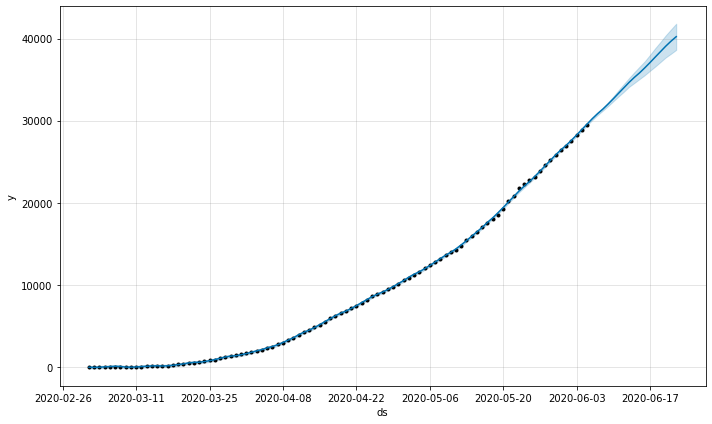

In [188]:
print(prophet_c.plot(confirmed_forecast))

In [189]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(datewise.index),list(datewise["Confirmed"])),columns=['ds','y'])

In [190]:
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [191]:
forecast_c=prophet_c.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()

In [192]:
confirmed_forecast=prophet_c.predict(forecast_c)
#print(confirmed_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

In [193]:
model_scores.append(np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(datewise["Confirmed"],confirmed_forecast['yhat'].head(datewise.shape[0]))))

Root Mean Squared Error for Prophet Model:  77.25585380476002


Figure(720x432)


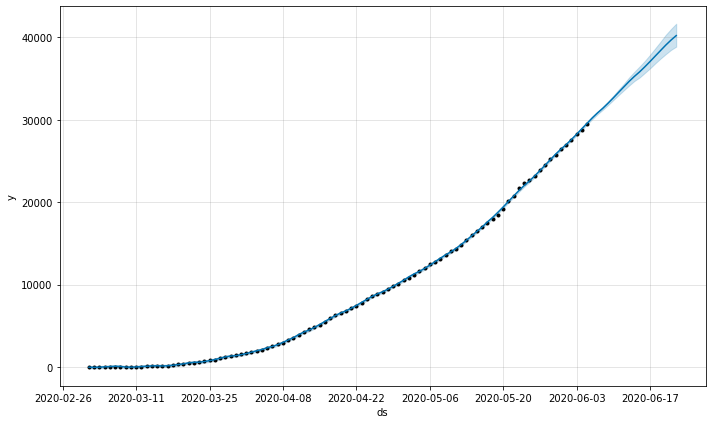

In [194]:
print(prophet_c.plot(confirmed_forecast))

Figure(648x432)


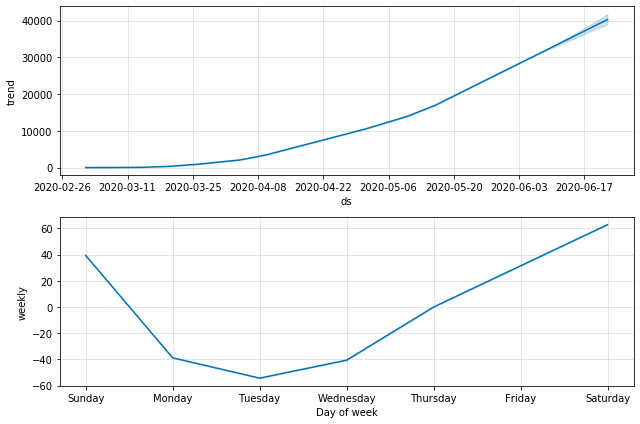

In [195]:
print(prophet_c.plot_components(confirmed_forecast))

In [196]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
9,Facebook's Prophet Model,77.255854
1,Polynomial Regression,141.218890
5,Auto Regressive Model (AR),277.636684
6,Moving Average Model (MA),277.710024
7,ARIMA Model,279.021027
8,SARIMA Model,279.021027
4,Holt's Winter Model,309.598108
3,Holt's Linear,3198.153484
0,Linear Regression,6462.449269
2,Support Vector Machine Regressor,11328.322767


In [197]:
model_predictions["Prophet's Prediction"]=list(confirmed_forecast["yhat"].tail(17))
model_predictions["Prophet's Upper Bound"]=list(confirmed_forecast["yhat_upper"].tail(17))
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction,Prophet's Prediction,Prophet's Upper Bound
0,2020-06-06,22633.279025,30437.192829,45671.341110,35804.179909,30885.619959,30561.092928,30538.146627,30540.108346,30540.108346,30241.122919,30391.393995
1,2020-06-07,22921.258640,31159.458079,47982.548494,37359.376561,31833.226391,31264.842954,31240.923665,31242.772468,31242.772468,30848.190871,30997.488322
2,2020-06-08,23209.238254,31890.989206,50391.054036,38914.573212,32292.869646,31987.225617,31951.629952,31953.358625,31953.358625,31400.514485,31592.019579
3,2020-06-09,23497.217869,32631.813738,52899.897979,40469.769864,32836.669257,32709.352430,32670.265490,32671.868608,32671.868608,32015.533711,32228.619081
4,2020-06-10,23785.197484,33381.959200,55512.183246,42024.966515,33805.186914,33446.038699,33396.830277,33398.302865,33398.302865,32659.816070,32916.898761


In [198]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Death Cases"))
fig.update_layout(title="Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [199]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [200]:
model_arima_deaths=auto_arima(model_train["Deaths"],trace=True, error_action='ignore', start_p=0,start_q=0,
                              max_p=2,max_q=2,suppress_warnings=True,stepwise=False,seasonal=False)     
model_arima_deaths.fit(model_train["Deaths"])

Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=739.105, BIC=744.082, Time=0.022 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=690.124, BIC=697.590, Time=0.047 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=691.705, BIC=701.660, Time=0.085 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=707.896, BIC=715.361, Time=0.031 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=691.639, BIC=701.593, Time=0.069 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=692.675, BIC=705.118, Time=0.132 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=701.272, BIC=711.226, Time=0.069 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=693.348, BIC=705.791, Time=0.100 seconds
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=693.485, BIC=708.417, Time=0.163 seconds
Total fit time: 0.717 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [201]:
predictions_deaths=model_arima_deaths.predict(len(valid))
y_pred["ARIMA Death Prediction"]=predictions_deaths

In [202]:
print("Root Mean Square Error: ",np.sqrt(mean_squared_error(valid["Deaths"],predictions_deaths)))

Root Mean Square Error:  29.57308020687376


In [203]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Train Data for Death Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Deaths"],
                    mode='lines+markers',name="Validation Data for Death Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Death Prediction"],
                    mode='lines+markers',name="Prediction for Death Cases",))
fig.update_layout(title="Death Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [204]:
ARIMA_model_death_forecast=[]
for i in range(1,18):
    ARIMA_model_death_forecast.append(model_arima_deaths.predict(len(valid)+i)[-1])

In [205]:
pd.DataFrame(zip(new_date,ARIMA_model_death_forecast),columns=["Deaths","ARIMA Model Death Forecast"]).head()

,Deaths,ARIMA Model Death Forecast
0,2020-06-06,1842.028670
1,2020-06-07,1881.696522
2,2020-06-08,1921.791920
3,2020-06-09,1962.314863
4,2020-06-10,2003.265351
